In [1]:
import cv2
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Add, BatchNormalization, Activation, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import json
import matplotlib.pyplot as plt

import time
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
train_dir = '160x160/train_set'
val_dir = '160x160/val_set'

# normalization
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# load iterate the dataset
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(160, 160),
    batch_size=64,
    color_mode="grayscale",
    class_mode='categorical',
    classes=[str(i) for i in range(7)]
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(160, 160),
    batch_size=64,
    color_mode="grayscale",
    class_mode='categorical',
    classes=[str(i) for i in range(7)]
)

Found 297074 images belonging to 7 classes.
Found 6568 images belonging to 7 classes.


In [3]:
def residual_block(x, filters, kernel_size=3, stride=1):
    shortcut = x
    x = Conv2D(filters, kernel_size=kernel_size, strides=stride, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, kernel_size=kernel_size, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    
    if stride != 1:
        shortcut = Conv2D(filters, kernel_size=1, strides=stride, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)
    
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)
    return x

In [4]:
def ResNet(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv2D(32, kernel_size=3, strides=1, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.5)(x)
    
    x = residual_block(x, 64, stride=2)
    x = residual_block(x, 128, stride=2)
    x = residual_block(x, 128, stride=2)
    
    x = GlobalAveragePooling2D()(x)
    x = Dense(3072)(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    return model

input_shape = (160, 160, 1)
num_classes = 7 # 7 emotions
start_time = time.time()
# train part
model = ResNet(input_shape, num_classes)
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.000033, epsilon=1e-6), metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

train_generator = train_generator
val_generator = val_generator

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=130,
    callbacks=[early_stopping]
)

print('Time in minutes:', ((time.time()-start_time)/60))
print('Time in hours:', ((time.time()-start_time)/3600))

Epoch 1/130


I0000 00:00:1729794988.054249  330603 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


4642/4642 [==============================] - 204s 42ms/step - loss: 1.4223 - accuracy: 0.4708 - val_loss: 2.1258 - val_accuracy: 0.2227
Epoch 2/130
4642/4642 [==============================] - 200s 43ms/step - loss: 1.3025 - accuracy: 0.5223 - val_loss: 2.0961 - val_accuracy: 0.2745
Epoch 3/130
4642/4642 [==============================] - 199s 43ms/step - loss: 1.1442 - accuracy: 0.5958 - val_loss: 1.9543 - val_accuracy: 0.3843
Epoch 4/130
4642/4642 [==============================] - 200s 43ms/step - loss: 1.0567 - accuracy: 0.6260 - val_loss: 1.8193 - val_accuracy: 0.4131
Epoch 5/130
4642/4642 [==============================] - 200s 43ms/step - loss: 1.0001 - accuracy: 0.6457 - val_loss: 1.7259 - val_accuracy: 0.4406
Epoch 6/130
4642/4642 [==============================] - 204s 44ms/step - loss: 0.9605 - accuracy: 0.6586 - val_loss: 1.5374 - val_accuracy: 0.4819
Epoch 7/130
4642/4642 [==============================] - 198s 43ms/step - loss: 0.9322 - accuracy: 0.6692 - val_loss: 1.6051

In [5]:
# the result
model_json = model.to_json()
with open("emotion_model.json", "w") as json_file:
    json_file.write(model_json)
#model.save_weights('new.weights.h5')

In [6]:
model.save("thisworks.h5")

/mounts/faraday/software/anaconda/envs/py311/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [7]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 160, 160, 32)         320       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 160, 160, 32)         128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 160, 160, 32)         0         ['batch_normalization[0][0

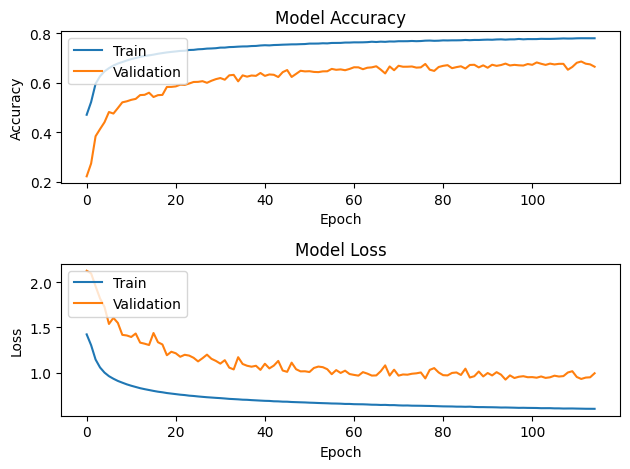

In [8]:
# plot training history
plt.figure(1)

# accuracy
plt.subplot(211)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# loss
plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.savefig('model_performance.png')

plt.show()